In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shapely as shp
import geopandas as gpd
import math
import random
import scipy.stats as stats
import xarray as xr
import itertools

In [5]:
'''Functions'''
def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [4]:
random.seed(12345)

## 2D Testing

In [5]:
#Declare some points
site = shp.Point((0, 0)).buffer(8)
p1 = shp.Point((-1.3, 1.7)).buffer(3) #tree 1
p2 = shp.Point((1.5, -0.25)).buffer(1.3) #tree 2
p3 = shp.Point((-3.2, -5.5)).buffer(2.5) #tree 3

In [6]:
#See how far they are from the center of the plot
print(p1.centroid.distance(shp.Point(0,0)))
print(p2.centroid.distance(shp.Point(0,0)))
print(p3.centroid.distance(shp.Point(0,0)))

2.1400934559032705
1.5206906325745548
6.363175307973213


(-8.0, 8.0)

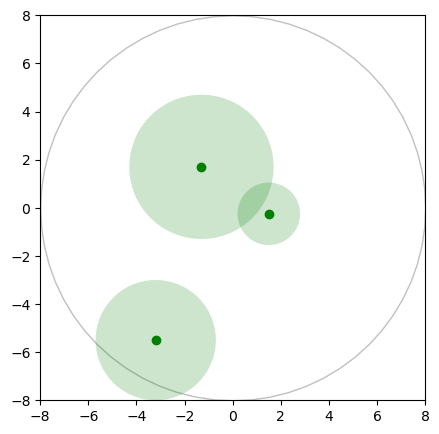

In [7]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for p in [p1, p2, p3]:
    gpd.GeoSeries(p).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(p.centroid).plot(ax = ax, color = 'green')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [8]:
#Try Generating random trees with a specific mean distance and sd
#Generate distances
dists = np.random.normal(loc = 4.2, scale = 2.1, size = 10)

#Check all are in correct range
while(dists > 8).any():
    dists = np.random.normal(loc = 4.2, scale = 2.1, size = 10)

#Generate DBHs (in cm)
dbhs = np.random.normal(loc = 32, scale = 3.4, size = 10)

#calculate crown diameter (using allometric equation for American Elm)
crown = (1.92 + 18.30*(dbhs/100))/2

#Generate locations
trees = []
start = site.centroid
for i in range(0, len(dists)):
    #assume on x axis and rotate a random number of degrees
    deg = np.random.uniform(low = 0, high = 2*math.pi)
    xx, yy = rotate_origin_only(dists[i], 0, deg)

    #create point
    trees.append(shp.Point((xx, yy)).buffer(crown[i]))
   
    

(-8.0, 8.0)

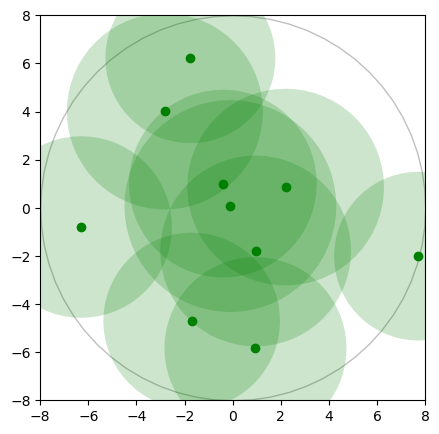

In [9]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [10]:
'''Calculate total overlap coverage'''
#Use shapely to calculate the total union and the intersection over the union
uni = shp.ops.unary_union(trees)

(-8.0, 8.0)

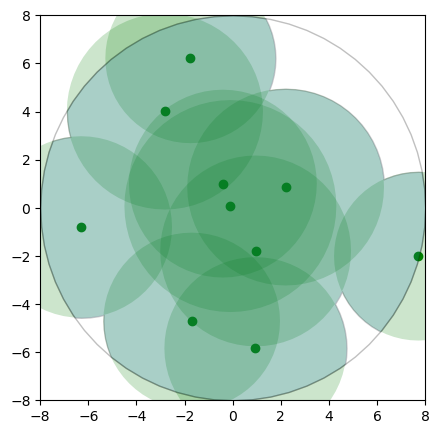

In [11]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

#clip and plot union
uni_clipped = gpd.GeoSeries(uni).clip(site)
gpd.GeoSeries(uni_clipped).plot(ax = ax, edgecolor = 'black', alpha = 0.2)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [12]:
#Calculate percent of site covered by tree
pcoverage = uni_clipped.area/site.area
pcoverage

0    0.905461
dtype: float64

In [13]:
'''Calculate total overlap'''

#Collect intersections recursively
temp = trees[0]
intersects = []
for tree in trees[1:]:
    #add intersection of unioned shape and new tree
    intersects.append(shp.intersection(tree, temp))
    #compute union
    temp = shp.union(tree, temp)

intersect = shp.ops.unary_union(intersects)

(-8.0, 8.0)

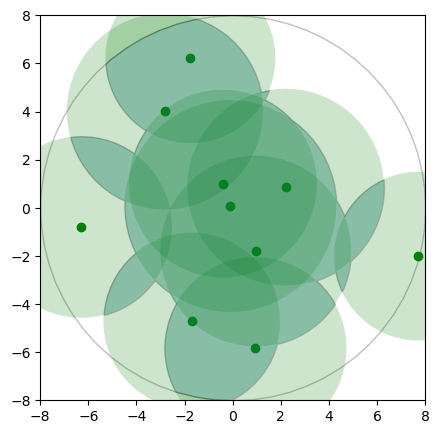

In [14]:
#Plot
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

gpd.GeoSeries(site).plot(ax = ax, edgecolor = 'silver', facecolor = 'white')
for tree in trees:
    gpd.GeoSeries(tree).plot(ax = ax, color = 'green', alpha = 0.2)
    gpd.GeoSeries(tree.centroid).plot(ax = ax, color = 'green')

#clip and plot union
int_clipped = gpd.GeoSeries(intersect).clip(site)
gpd.GeoSeries(int_clipped).plot(ax = ax, edgecolor = 'black', alpha = 0.2)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

In [15]:
#Calculate percent of site overlapped
poverlap = int_clipped.area/site.area
poverlap

0    0.559765
dtype: float64

## 2D Function

In [16]:
'''Combine into function'''

def simulateSite(n, distMu, distSigma, dbhMu, dbhSigma, pCon, plots = False):
    #Step 1: Generate site
    site = shp.Point((0, 0)).buffer(8)

    #Generate distances
    dists = np.random.normal(loc = distMu, scale = distSigma, size = n)

    #Check all are in correct range
    while ((dists > 8).any()) | ((dists < 0).any()):
        dists = np.random.normal(loc = distMu, scale = distSigma, size = n)

    #Generate DBHs (in cm)
    dbhs = np.random.normal(loc = dbhMu, scale = dbhSigma, size = n)

    #Check all are in correct range
    while(dbhs < 0).any():
        dbhs = np.random.normal(loc = dbhMu, scale = dbhSigma, size = n)

    #Generate conif crown widths 
    conifCC = (stats.gamma.rvs(2.84604046158689, loc=-1.8990921243783796, scale=14.411867120014431, size=n))/100
    while(conifCC < 0).any():
        conifCC = (stats.gamma.rvs(2.84604046158689, loc=-1.8990921243783796, scale=14.411867120014431, size=n))/100

    #Based on pCon, assign crown width for conif and decid trees
    nCon = int(n*pCon)
    crown = np.zeros(n)
    #take first nCon trees:
    if nCon == n:
        #For sites with all conifers, just take all simulated crown data
        crown = conifCC
    elif (nCon > 0) & (nCon < n):
        #CONIFEROUS - take first nCon values
        crown[0:nCon+1] = conifCC[0:nCon+1]
        #DECIDUOUS - calculate crown diameter (using allometric equation for american elm)
        crown[nCon+1:] = (1.92 + 18.30*(dbhs[nCon+1:]/100))/2
    else:
        #try just using DBH instead of overestimated canopy 
        crown = (1.92 + 18.30*(dbhs/100))/2

    #Generate locations
    trees = []
    start = site.centroid
    for i in range(0, len(dists)):
        #assume on x axis and rotate a random number of degrees
        deg = np.random.uniform(low = 0, high = 2*math.pi)
        xx, yy = rotate_origin_only(dists[i], 0, deg)

        #create point
        trees.append(shp.Point((xx, yy)).buffer(crown[i]))


    #Step 1.5: Calculate total tree canopy
    areas = [tree.area for tree in trees]
    tot = np.cumsum(areas)[-1]

    #Step 2: Calculate total plot coverage
    #Use shapely to calculate the total union and the intersection over the union
    uni = shp.ops.unary_union(trees)
    uni_clipped = gpd.GeoSeries(uni).clip(site)
    pcoverage = float(uni_clipped.area/site.area)

    #Step 3: Calculate total overlap
    #Collect intersections recursively
    temp = trees[0]
    intersects = []
    for tree in trees[1:]:
        #add intersection of unioned shape and new tree
        intersects.append(shp.intersection(tree, temp))
        #compute union
        temp = shp.union(tree, temp)

    #Merge
    intersect = shp.ops.unary_union(intersects)
    int_clipped = gpd.GeoSeries(intersect).clip(site)
    
    if(len(int_clipped.area) > 0):
        poverlap = float(int_clipped.area/site.area)
    else:
        poverlap = 0

    #Step 4: Plot
    if(plots):
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (5,  10), 
                                            sharex = True, 
                                            sharey = True, 
                                            layout = 'tight')

        #Plot union
        gpd.GeoSeries(site).plot(ax = ax1, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax1, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax1, color = 'green')
        gpd.GeoSeries(uni_clipped).plot(ax = ax1, edgecolor = 'black', alpha = 0.2)

        #Plot intersection
        gpd.GeoSeries(site).plot(ax = ax2, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax2, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax2, color = 'green')

        #clip and plot union
        gpd.GeoSeries(int_clipped).plot(ax = ax2, edgecolor = 'black', alpha = 0.2)

        ax1.set_xlim(-8, 8)
        ax1.set_ylim(-8, 8)
        ax1.set_title('Total Plot Coverage: ' + str(np.round(pcoverage, 2)), loc = 'left', size = 'small')
        ax2.set_xlim(-8, 8)
        ax2.set_ylim(-8, 8)
        ax2.set_title('Total Plot Overlap: ' + str(np.round(poverlap, 2)), loc = 'left', size = 'small')

    return pcoverage, poverlap, tot

C:\Users\marie\AppData\Local\Temp\ipykernel_23080\1210111303.py:62: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pcoverage = float(uni_clipped.area/site.area)
C:\Users\marie\AppData\Local\Temp\ipykernel_23080\1210111303.py:79: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  poverlap = float(int_clipped.area/site.area)


(0.7656305338000257, 0.38986850626499076, 352.68596530542027)

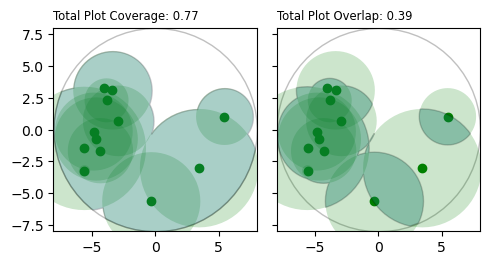

In [17]:
simulateSite(12, 4.2, 1.4, 22.8, 10.5, 0.11, plots = True)

## 3D Testing

In [18]:
#Declare some trees
site = shp.Point((0, 0)).buffer(8)
p1 = shp.Point((-1.3, 1.7)).buffer(3) #tree 1
p2 = shp.Point((1.5, -0.25)).buffer(1.3) #tree 2
p3 = shp.Point((-3.2, -5.5)).buffer(2.5) #tree 3

In [19]:
#Zip together x and y data with 0 z value
x = p1.exterior.xy[0]
y = p1.exterior.xy[1]
treeBase = list(zip(x, y, np.zeros(len(x))))
treeTop = (p1.centroid.x, p1.centroid.y, 3)
treeBase.append(treeTop)
tree = shp.Polygon(treeBase)

(0.0, 4.0)

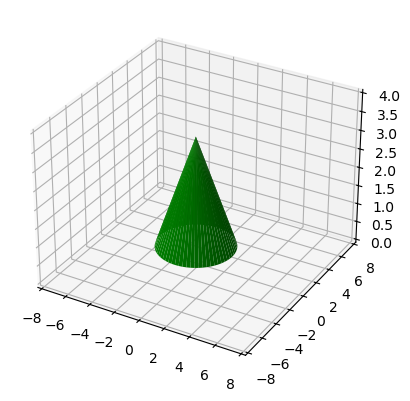

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
coor = list(shp.get_exterior_ring(tree).coords)
l = len(coor)
x = [coor[i][0] for i in range(0, l)]
y = [coor[i][1] for i in range(0, l)]
z = [coor[i][2] for i in range(0, l)]
ax.plot_trisurf(x, y, z, color = 'green')
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(0, 4)

(0.0, 4.0)

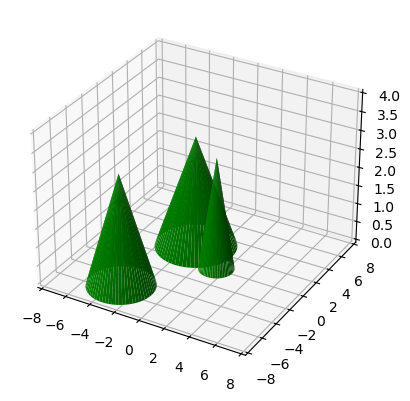

In [21]:
#Try Generating small forest with all trees:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

trees = []

for p in [p1, p2, p3]:
    #Zip together x and y data with 0 z value
    x = p.exterior.xy[0]
    y = p.exterior.xy[1]
    treeBase = list(zip(x, y, np.zeros(len(x))))
    treeTop = (p.centroid.x, p.centroid.y, 3) #for now make them all the same height
    treeBase.append(treeTop)
    #Make polygon
    tree = shp.Polygon(treeBase)
    #plot
    coor = list(shp.get_exterior_ring(tree).coords)
    l = len(coor)
    x2 = [coor[i][0] for i in range(0, l)]
    y2 = [coor[i][1] for i in range(0, l)]
    z2 = [coor[i][2] for i in range(0, l)]
    ax.plot_trisurf(x2, y2, z2, color = 'green')

    trees.append(tree)

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(0, 4)

In [22]:
#Try some cylinders
d1 = shp.Point((-2, 1.3)).buffer(0.1) #tree 1
d2 = shp.Point((4.3, -0.25)).buffer(0.05) #tree 2
d3 = shp.Point((-5.1, 2.5)).buffer(0.05) #tree 3

(0.0, 6.0)

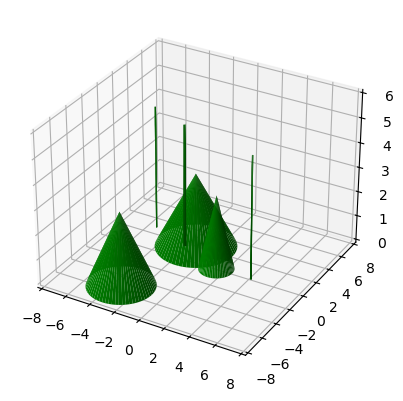

In [23]:
#Try Generating small forest with all trees:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for p in [p1, p2, p3]:
    #Zip together x and y data with 0 z value
    x = p.exterior.xy[0]
    y = p.exterior.xy[1]
    treeBase = list(zip(x, y, np.zeros(len(x))))
    treeTop = (p.centroid.x, p.centroid.y, 3) #for now make them all the same height
    treeBase.append(treeTop)
    #Make polygon
    tree = shp.Polygon(treeBase)
    #plot
    coor = list(shp.get_exterior_ring(tree).coords)
    l = len(coor)
    x2 = [coor[i][0] for i in range(0, l)]
    y2 = [coor[i][1] for i in range(0, l)]
    z2 = [coor[i][2] for i in range(0, l)]
    ax.plot_trisurf(x2, y2, z2, color = 'green')

for d in [d1, d2, d3]:
    #Zip together x and y data with 0 z value
    x = d.exterior.xy[0]
    y = d.exterior.xy[1]
    treeBase = list(zip(x, y, np.zeros(len(x))))
    treeTop = list(zip(x, y, 5*np.ones(len(x)))) 
    treeOut = treeBase + treeTop
    #Make polygon
    tree = shp.Polygon(treeOut)
    #plot
    coor = list(shp.get_exterior_ring(tree).coords)
    l = len(coor)
    x2 = [coor[i][0] for i in range(0, l)]
    y2 = [coor[i][1] for i in range(0, l)]
    z2 = [coor[i][2] for i in range(0, l)]
    ax.plot_trisurf(x2, y2, z2, color = 'green')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(0, 6)

In [24]:
'''Coverage'''
#Use shapely to calculate the total union and the intersection over the union
uni = shp.union_all(trees)

(0.0, 5.0)

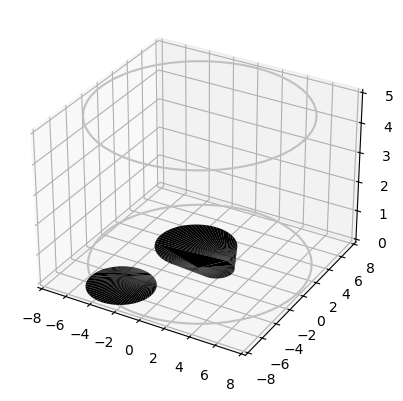

In [25]:
#clip and plot union
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_aspect('auto', 'box')

#Plot site
site_outline = list(shp.get_exterior_ring(site).coords)
sitex = [site_outline[i][0] for i in range(0, len(site_outline))]
sitey = [site_outline[i][1] for i in range(0, len(site_outline))]
sitetop = 5*np.ones(len(site_outline))
sitebottom = np.zeros(len(site_outline))
site3D = shp.Polygon(list(zip(sitex, sitey, sitebottom)) + list(zip(sitex, sitey, sitetop)))
ax.plot(sitex, sitey, sitebottom, color = 'silver')
ax.plot(sitex, sitey, sitetop, color = 'silver')

#Plot trees
#for tree in trees:
#    #plot
#    coor = list(shp.get_exterior_ring(tree).coords)
#    l = len(coor)
#    x2 = [coor[i][0] for i in range(0, l)]
#    y2 = [coor[i][1] for i in range(0, l)]
#    z2 = [coor[i][2] for i in range(0, l)]
#    ax.plot_trisurf(x2, y2, z2, color = 'green')

#Plot Unions
uni_clipped = shp.intersection_all([uni, site3D])

for g in uni.geoms:
     #plot
    ob = list(shp.get_exterior_ring(g).coords)
    l = len(ob)
    x3 = [ob[i][0] for i in range(0, l)]
    y3 = [ob[i][1] for i in range(0, l)]
    z3 = [ob[i][2] for i in range(0, l)]
    ax.plot_trisurf(x3, y3, z3, color = 'black')

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_zlim(0, 5)


In [26]:
list(trees[0].exterior.coords)

[(1.7, 1.7, 0.0),
 (1.6855541800165905, 1.4059485790113182, 0.0),
 (1.6423558412096912, 1.1147290339516152, 0.0),
 (1.5708210071966267, 0.8291459682366129, 0.0),
 (1.47163859753386, 0.5519497029047307, 0.0),
 (1.3457637930450652, 0.2858097895220071, 0.0),
 (1.1944088369076356, 0.03328930094119342, 0.0),
 (1.019031360088211, -0.2031798524909365, 0.0),
 (0.8213203435596428, -0.4213203435596429, 0.0),
 (0.6031798524909364, -0.6190313600882107, 0.0),
 (0.36671069905880693, -0.7944088369076356, 0.0),
 (0.11419021047799327, -0.9457637930450649, 0.0),
 (-0.15194970290473053, -1.07163859753386, 0.0),
 (-0.429145968236613, -1.1708210071966267, 0.0),
 (-0.714729033951615, -1.2423558412096913, 0.0),
 (-1.0059485790113176, -1.2855541800165906, 0.0),
 (-1.2999999999999998, -1.3, 0.0),
 (-1.594051420988682, -1.2855541800165906, 0.0),
 (-1.8852709660483846, -1.2423558412096913, 0.0),
 (-2.1708540317633864, -1.1708210071966267, 0.0),
 (-2.4480502970952696, -1.07163859753386, 0.0),
 (-2.714190210477993

## Concatenate LAI, Snow, and vegetation data

In [27]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset('./data/01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset('./data/01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

### Import forestry Data -- summarized by stake
forestInv = pd.read_csv('./data/vegdata_withsnow.csv')

In [28]:
#Select necessary forest data
forest = forestInv[['Stake_ID', 'OLS.Prediction.Ring.5', 'DIST_FT', 'DIST_M', 'DBH_IN', 'DBH_CM',
       'DIST_FT_SD', 'DIST_M_SD', 'DBH_IN_SD', 'DBH_CM_SD', 'n', 'prop_Coniferous', 'Co']]

#Snow year
allSnow_df['SYear'] = [2024 if allSnow_df.time[i] > pd.to_datetime('09-01-2023') else 2023 for i in range(0, len(allSnow_df.time))]

#Remove Nan
allSnow_nan = allSnow_df.dropna().reset_index(drop = True)

#Take peak snow depth per site
peakSnow = allSnow_nan.groupby(['stakes', 'northing', 'easting', 'zones', 'aspect', 'slope', 'watershed', 'SYear'])['depths'].max().reset_index()
peakSnow = peakSnow.rename(columns = {'depths' : 'maxDepth'})

In [29]:
peakSnow

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0
4,S202,464819.0,5262344.0,Upland,352.4059,2.166370,S2,2023,33.0
...,...,...,...,...,...,...,...,...,...
103,S646,464582.2,5262240.0,Upland,166.1192,3.132299,S6,2024,20.0
104,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2023,57.0
105,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2024,17.0
106,S655,464644.0,5262449.0,Upland,259.7763,6.629145,S6,2023,60.0


In [30]:
#Merge with snow data
merged = pd.merge(peakSnow, forest, left_on = 'stakes', right_on = 'Stake_ID')
merged

,stakes,northing,easting,zones,aspect,slope,watershed,SYear,maxDepth,Stake_ID,...,DIST_M,DBH_IN,DBH_CM,DIST_FT_SD,DIST_M_SD,DBH_IN_SD,DBH_CM_SD,n,prop_Coniferous,Co
0,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2023,70.0,S200,...,5.354320,8.261155,20.983333,4.232415,1.290040,3.001851,7.624701,12,0.000000,7
1,S200,464819.0,5262240.0,Upland,193.3626,6.632267,S2,2024,22.0,S200,...,5.354320,8.261155,20.983333,4.232415,1.290040,3.001851,7.624701,12,0.000000,7
2,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2023,59.0,S201,...,4.480560,9.534121,24.216667,5.262967,1.604152,4.554940,11.569547,18,0.111111,9
3,S201,464819.0,5262292.0,Upland,115.0966,3.120716,S2,2024,18.0,S201,...,4.480560,9.534121,24.216667,5.262967,1.604152,4.554940,11.569547,18,0.111111,9
4,S203,464819.0,5262396.0,Upland,135.0012,7.452870,S2,2023,49.0,S203,...,5.025390,5.725886,14.543750,6.042944,1.841889,1.568753,3.984632,16,0.437500,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,S646,464582.2,5262240.0,Upland,166.1192,3.132299,S6,2024,20.0,S646,...,4.842191,6.896922,17.518182,5.132963,1.564527,1.407426,3.574862,11,1.000000,10
96,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2023,57.0,S654,...,5.958172,6.962447,17.684615,5.905921,1.800125,2.433891,6.182083,26,0.000000,15
97,S654,464644.0,5262658.0,Upland,350.3666,1.924451,S6,2024,17.0,S654,...,5.958172,6.962447,17.684615,5.905921,1.800125,2.433891,6.182083,26,0.000000,15
98,S655,464644.0,5262449.0,Upland,259.7763,6.629145,S6,2023,60.0,S655,...,4.594945,6.303587,16.011111,5.932379,1.808189,2.537889,6.446238,18,0.444444,10


In [31]:
#Save to dataframe
merged.to_csv('./data/compiled_data_formodel.csv', index = False)

## Concatenate tree specific vegetation data

In [10]:
#load data
treeDataS2 = pd.read_csv('./data/S2overstory_2023_compiled.csv', 
                        dtype = {'SITE': str, 'COMMON_NAME': str, 'SPECIES': str,
                                 'DIST_FT': float, 'DIST_M': float, 'DBH_IN':float, 'DBH_CM': float, 
                                 'CC': str, 'NORTHING': float, 'EASTING':float})
treeDataS6 = pd.read_csv('./data/S6overstory_2023_compiled.csv', 
                        dtype = {'SITE': str, 'COMMON_NAME': str, 'SPECIES': str,
                                 'DIST_FT': float, 'DIST_M': float, 'DBH_IN':str, 'DBH_CM': str, 
                                 'CC': str, 'NORTHING': float, 'EASTING':float})

#concatenate
treeData = pd.concat([treeDataS2, treeDataS6]).reset_index(drop = True)

#Add conif column
treeData['Con'] = [True if sp in ('Abies balsamea', 'Picea mariana', 'Larix laricina', 'Picea glauca', 'Pinus resinosa', 'Pinus Strobus') else False for sp in treeData.SPECIES]


print(treeData)

     SITE       COMMON_NAME              SPECIES  DIST_FT    DIST_M  \
0    S200     Quaking Aspen  Populus tremuloides   18.500  5.640000   
1    S200       Sugar Maple       Acer saccharum   12.900  3.930000   
2    S200       Sugar Maple       Acer saccharum   11.900  3.630000   
3    S200       Sugar Maple       Acer saccharum   12.400  3.780000   
4    S200       Sugar Maple       Acer saccharum   23.700  7.220000   
..    ...               ...                  ...      ...       ...   
889  S655       Paper Birch    Betula papyrifera   20.667  6.299302   
890  S655       Paper Birch    Betula papyrifera   17.333  5.283098   
891  S655       Paper Birch    Betula papyrifera   23.500  7.162800   
892  S655  Northern Red Oak        Quercus rubra    5.417  1.651102   
893  S655  Northern Red Oak        Quercus rubra   16.750  5.105400   

          DBH_IN DBH_CM   CC  NORTHING    EASTING    Con  
0          14.76   37.5  Dom  464471.0  5262521.0  False  
1            6.3   16.0  Int 

In [ ]:
#subset trees to a specific site
trees = treeData[treeData.SITE == 'S236'].reset_index(drop = True)

In [ ]:
trees

,SITE,COMMON_NAME,SPECIES,DIST_FT,DIST_M,DBH_IN,DBH_CM,CC,NORTHING,EASTING,Con
0,S236,Red Maple,Acer rubrum,9.1,2.77,9.61,24.4,Co,464819,5262358,False
1,S236,Red Maple,Acer rubrum,9.3,2.83,9.65,24.5,Co,464819,5262358,False
2,S236,Red Maple,Acer rubrum,22.9,6.98,6.46,16.4,Co,464819,5262358,False
3,S236,Red Maple,Acer rubrum,23.8,7.25,5.43,13.8,Co,464819,5262358,False
4,S236,Red Maple,Acer rubrum,16.3,4.97,9.92,25.2,Co,464819,5262358,False
5,S236,Balsam Fir,Abies balsamea,17.7,5.39,11.93,30.3,Int,464819,5262358,True
6,S236,Balsam Fir,Abies balsamea,23.9,7.28,4.76,12.1,Sup,464819,5262358,True
7,S236,White Ash,Fraxinus americana,22.3,6.80,5.39,13.7,Co,464819,5262358,False
8,S236,White Ash,Fraxinus americana,16.7,5.09,3.94,10.0,Co,464819,5262358,False
9,S236,White Ash,Fraxinus americana,4.8,1.46,5.04,12.8,Int,464819,5262358,False


In [ ]:
def createTree2D(dbh, dist, con, ba):
    if con:
        #Simulate coniferous trees as Black Spruce
        #Calculate height
        height_ft = 4.5 + 2136.9468*math.exp(-6.2688*math.pow(dbh, -0.2161)) #feet
        height = height_ft*0.3048 #transform to m
        #Calulate crown ratio
        cr = 10*(5.540/(1 + 0.0072*ba)) + (4.200*(1 - math.exp(-0.0530*dbh)))
        #Calculate crown
        crown_ft = -0.8566 + 0.9693*dbh + 0.0573*cr   
        crown = (crown_ft*0.3048)/2
    else:
        #Simulate deciduous trees as Red Maple
        #Calculate height
        height_ft = 4.5 * math.exp(4.3379 + ((-3.8214)/(dbh + 1))) #feet
        height = height_ft*0.3048 #transform to m
        #Calulate crown ratio
        #cr = 10*(4.340/(1 + 0.0046*ba)) + (1.820*(1 - math.exp(-0.2740*dbh)))
        #Calculate crown
        #crown_ft = 2.7562 + 1.4212*dbh - 0.0143*math.pow(dbh, 2) + 0.0993*cr - 0.0276*hi 
        #crown = crown_ft*0.3048
        #Simply use BA as crown width
        crown = (dbh*0.0254)/2 #in to m then to radius
    
    #Rotate location
    #assume on x axis and rotate a random number of degrees
    deg = np.random.uniform(low = 0, high = 2*math.pi)
    xx, yy = rotate_origin_only(dist, 0, deg)

    #create point
    return shp.Point((xx, yy)).buffer(crown) 

def simulateTrees(trees, plots = False):
    #Step 1: Generate site
    site = shp.Point((0, 0)).buffer(8)

    #Collect distances
    dists = list(trees.DIST_M)

    #Collect DBHs 
    dbhs = list(trees.DBH_IN)

    #Calculate Basal Area for site (m2/hectare)
    BA = sum([math.pi*((d/2)**2)*(1/(math.pi*((26.2)**2)))*(1/0.00000929)*(0.001) for d in dbhs])

    #Based on pCon, assign conifs
    con = list(trees.Con)

    #Generate locations
    trees = []
    for i in range(0, len(dists)):
        trees.append(createTree2D(dbhs[i], dists[i], con[i], BA))


    #Step 1.5: Calculate total tree canopy
    areas = [tree.area for tree in trees]
    tot = np.cumsum(areas)[-1]

    #Step 2: Calculate total plot coverage
    #Use shapely to calculate the total union and the intersection over the union
    uni = shp.ops.unary_union(trees)
    uni_clipped = gpd.GeoSeries(uni).clip(site)
    pcoverage = float(uni_clipped.area/site.area)

    #Step 3: Calculate total overlap
    #Collect intersections recursively
    temp = trees[0]
    intersects = []
    for tree in trees[1:]:
        #add intersection of unioned shape and new tree
        intersects.append(shp.intersection(tree, temp))
        #compute union
        temp = shp.union(tree, temp)

    #Merge
    intersect = shp.ops.unary_union(intersects)
    int_clipped = gpd.GeoSeries(intersect).clip(site)
    
    if(len(int_clipped.area) > 0):
        poverlap = float(int_clipped.area/site.area)
    else:
        poverlap = 0

    #Step 4: Plot
    if(plots):
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (5,  10), 
                                            sharex = True, 
                                            sharey = True, 
                                            layout = 'tight')

        #Plot union
        gpd.GeoSeries(site).plot(ax = ax1, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax1, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax1, color = 'green')
        gpd.GeoSeries(uni_clipped).plot(ax = ax1, edgecolor = 'black', alpha = 0.2)

        #Plot intersection
        gpd.GeoSeries(site).plot(ax = ax2, edgecolor = 'silver', facecolor = 'white')
        for tree in trees:
            gpd.GeoSeries(tree).plot(ax = ax2, color = 'green', alpha = 0.2)
            gpd.GeoSeries(tree.centroid).plot(ax = ax2, color = 'green')

        #clip and plot union
        gpd.GeoSeries(int_clipped).plot(ax = ax2, edgecolor = 'black', alpha = 0.2)

        ax1.set_xlim(-8, 8)
        ax1.set_ylim(-8, 8)
        ax1.set_title('Total Plot Coverage: ' + str(np.round(pcoverage, 2)), loc = 'left', size = 'small')
        ax2.set_xlim(-8, 8)
        ax2.set_ylim(-8, 8)
        ax2.set_title('Total Plot Overlap: ' + str(np.round(poverlap, 2)), loc = 'left', size = 'small')

    return pcoverage, poverlap, tot

C:\Users\marie\AppData\Local\Temp\ipykernel_7744\1639934877.py:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pcoverage = float(uni_clipped.area/site.area)
c:\Users\marie\anaconda3\lib\site-packages\geopandas\array.py:1019: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
c:\Users\marie\anaconda3\lib\site-packages\geopandas\array.py:1020: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
c:\Users\marie\anaconda3\lib\site-packages\geopandas\array.py:1021: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
c:\Users\marie\anaconda3\lib\site-packages\geopandas\array.py:1022: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
C:\Users\marie\AppData\Local\Temp\ipykernel_7744\1639934877.py:105: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  gpd.GeoSeries(int_cl

(0.08168945829304729, 0, 16.681103376373184)

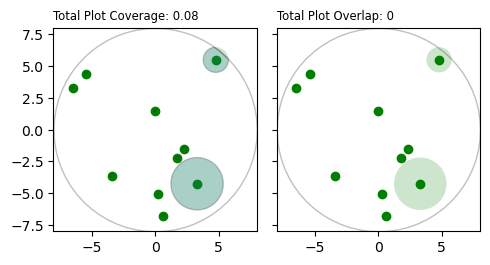

In [ ]:
simulateTrees(trees, plots = True)

# Setup for Sensitivity Analysis

In [27]:
dists = 8*stats.uniform.rvs(size = 10)
dbhs = 40*stats.uniform.rvs(size = 10)
dbhs

array([ 9.74705462, 23.34624372, 25.12433653, 32.92935397, 20.73856254,
       36.21779028, 25.27426968, 13.58330638, 33.06381547, 30.96072035])

In [36]:
combs = list(itertools.product(dists, dbhs))
distm = []
dbhscm = []
for i in range(0, len(combs)):
    distm.append(combs[i][0])
    dbhscm.append(combs[i][1])

synthData = pd.DataFrame({'DIST_M' : distm, 
                          'DBH_CM' : dbhscm})

In [37]:
synthData

,DIST_M,DBH_CM
0,1.752228,9.747055
1,1.752228,23.346244
2,1.752228,25.124337
3,1.752228,32.929354
4,1.752228,20.738563
...,...,...
95,2.522955,36.217790
96,2.522955,25.274270
97,2.522955,13.583306
98,2.522955,33.063815
